In [416]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.models.base.geodesic_ae import GeodesicAE

from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

import seaborn as sns

import copy

sc.set_figure_params(figsize=(3, 3))

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [2]:
def lerp(a, b, t):
    return a + (b - a) * t

## Plotting function

## Testing

In [34]:
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scCFM/project_dir/data/pancreas/processed/pancreas.h5ad")

In [35]:
model_vae={
       'in_dim': 2000,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={
    "compute_metrics_every": 1,
    "use_c": False,
    "trainable_c": False,
    "l2": True,
    "eta_interp": 0,
    "interpolate_z": False,
    "start_jac_after": 0,
    "detach_theta": False,
    "fl_weight": 1,
    "anneal_fl_weight": False,
    "max_fl_weight": None,
    "n_epochs_anneal_fl": None,
    "fl_anneal_fraction": None
}

In [36]:
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()

In [37]:
geometric_vae.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scCFM/project_dir/checkpoints/ae/pancreas/best_model_geometric_lib.ckpt")["state_dict"])
# geometric_vae.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scCFM/project_dir/baselines/flatvi/model.ckpt")["state_dict"])
# geometric_vae.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scCFM/project_dir/baselines/flatvi/model_1.ckpt")["state_dict"])

<All keys matched successfully>

In [66]:
# X_expression = torch.from_numpy(adata.layers["X_norm"].A)
# library_size = X_expression.sum(1)

In [67]:
# X_expression.sum(1)

In [68]:
# with torch.no_grad():
#     z, _, _ = geometric_vae.encode(X_expression).values()
#     # X_recon = torch.softmax(geometric_vae.decode(z), 1)*library_size.unsqueeze(1)
#     X_recon = geometric_vae.sample_decoder(z, library_size).cpu()

Check reconstructions 

In [69]:
# recon_adata = sc.AnnData(X=copy.deepcopy(X_recon.numpy()),
#                          obs=adata.obs.copy())

# # sc.pp.normalize_total(recon_adata)
# sc.pp.log1p(recon_adata)
# recon_adata.var = adata.var.copy()

In [70]:
# sc.tl.pca(recon_adata)
# sc.pp.neighbors(recon_adata)
# sc.tl.umap(recon_adata)

In [71]:
# sc.pl.umap(recon_adata, color="celltype")

In [72]:
# sc.pl.pca(recon_adata, color=['Ppp3ca', 
#                          'Cpe',
#                          'Nnat',
#                          'Top2a',
#                          'Sst',
#                          'Smarca1',
#                          'Cdkn1a',
#                          'Ppp1r1a'])

Check encodings 

In [73]:
# recon_adata_z = sc.AnnData(X=z.numpy(), obs=adata.obs.copy())

In [74]:
# sc.tl.pca(recon_adata_z)
# sc.pp.neighbors(recon_adata_z)
# sc.tl.umap(recon_adata_z)

In [75]:
# sc.pl.umap(recon_adata_z, color="celltype")

Overlay

In [76]:
# annot_true_recon = {"dataset": ["True" for _ in range(len(X_expression))]+["Gen" for _ in range(len(X_expression))]}

In [77]:
# adata_joint = sc.AnnData(X=np.concatenate([X_expression, X_recon.numpy()], axis=0), 
#                         obs=annot_true_recon)

In [78]:
# sc.tl.pca(adata_joint)
# sc.pp.neighbors(adata_joint)
# sc.tl.umap(adata_joint)

In [79]:
# sc.pl.umap(adata_joint, color="dataset")

# Now perform the interpolation between a bunch of cell types

In [52]:
geometric_vae = geometric_vae.eval()

In [413]:
# def plot_gene_expression_by_celltype(adata, 
#                                      celltype_order, 
#                                      gene, 
#                                      predicted_expression=None, 
#                                      predicted_expression_baseline=None, 
#                                      plot_average=True,
#                                      idx_ct1=None,
#                                      idx_ct2=None, 
#                                      save_path=None,
#                                      plt_legend=False):
#     """
#     Plots gene expression as a categorical scatter plot across specified cell types
#     and overlays an interpolated prediction curve if provided.
#     """

#     if gene not in adata.var_names:
#         raise ValueError(f"Gene '{gene}' not found in adata.var_names.")

#     gene_idx = list(adata.var_names).index(gene)

#     # Prepare data
#     plot_data = []
#     for celltype in celltype_order:
#         expr_values = adata[adata.obs["celltype"] == celltype].X[:, gene_idx].toarray().flatten()
#         plot_data.append(pd.DataFrame({"Expression": expr_values, "Cell Type": celltype}))

#     df_plot = pd.concat(plot_data)

#     # Plot on a single axis
#     fig, ax = plt.subplots(figsize=(4, 3.5))

#     # Use stripplot instead of catplot to control layering
#     sns.stripplot(
#         data=df_plot,
#         x="Cell Type",
#         y="Expression",
#         order=celltype_order,
#         jitter=True,
#         color="darkgray",
#         ax=ax,
#         zorder=2, 
#         alpha=0.3, 
#     )


#     # Map categories to numeric x-axis for plotting predictions
#     celltype_positions = np.arange(len(celltype_order))

#     # Plot predictions
#     if predicted_expression is not None:
#         timepoints = np.linspace(0, len(celltype_order) - 1, 100)

#         if plot_average:
#             # FlatVI
#             pred_mean = np.mean(predicted_expression[:, :, gene_idx], axis=1)
#             pred_std = np.std(predicted_expression[:, :, gene_idx], axis=1)
            
#             # Mean line
#             ax.plot(timepoints, pred_mean, color="firebrick", lw=2, label="FlatVI", zorder=1)
            
#             # Confidence band fill
#             ax.fill_between(timepoints, pred_mean - pred_std, pred_mean + pred_std,
#                             color="firebrick", alpha=0.2, zorder=0)
            
#             # Dashed boundary lines
#             ax.plot(timepoints, pred_mean + pred_std, color="firebrick", lw=1, ls='--', zorder=0, alpha=0.5)
#             ax.plot(timepoints, pred_mean - pred_std, color="firebrick", lw=1, ls='--', zorder=0, alpha=0.5)
            
#             # GAGA (if provided)
#             if predicted_expression_baseline is not None:
#                 pred_mean_baseline = np.mean(predicted_expression_baseline[:, :, gene_idx], axis=1)
#                 pred_std_baseline = np.std(predicted_expression_baseline[:, :, gene_idx], axis=1)
            
#                 ax.plot(timepoints, pred_mean_baseline, color="deepskyblue", lw=2, label="GAGA", zorder=1)
            
#                 ax.fill_between(timepoints, pred_mean_baseline - pred_std_baseline, 
#                                 pred_mean_baseline + pred_std_baseline,
#                                 color="deepskyblue", alpha=0.1, zorder=0)
            
#                 ax.plot(timepoints, pred_mean_baseline + pred_std_baseline, color="deepskyblue", lw=1, ls='--', zorder=0, alpha=0.5)
#                 ax.plot(timepoints, pred_mean_baseline - pred_std_baseline, color="deepskyblue", lw=1, ls='--', zorder=0, alpha=0.5)

#         else:
#             for i in range(predicted_expression.shape[1]):
#                 sns.lineplot(x=timepoints, y=predicted_expression[:, i, gene_idx], 
#                              color="firebrick", alpha=0.3, lw=1, ax=ax, label=None, zorder=1)
#                 if predicted_expression_baseline is not None:
#                     sns.lineplot(x=timepoints, y=predicted_expression_baseline[:, i, gene_idx], 
#                                  color="deepskyblue", alpha=0.3, lw=1, ax=ax, label=None, zorder=1)
#             # Single lines for legend
#             sns.lineplot(x=timepoints, y=predicted_expression[:, 0, gene_idx], 
#                          color="firebrick", lw=2, ax=ax, label="FlatVI", zorder=1)
#             if predicted_expression_baseline is not None:
#                 sns.lineplot(x=timepoints, y=predicted_expression_baseline[:, 0, gene_idx], 
#                              color="deepskyblue", lw=2, ax=ax, label="GAGA", zorder=1)

#     # Final touches
#     ax.set_xticks(celltype_positions)
#     ax.set_xticklabels(celltype_order, rotation=45, fontsize=12)
#     ax.set_xlabel("Lineage →", fontsize=12)
#     ax.set_ylabel("Expression", fontsize=12)
#     ax.set_title(f"Lineage: {celltype_order[0]} → {celltype_order[-1]} / Marker: {gene}", fontsize=12)
#     if plt_legend:
#         ax.legend()

#     plt.tight_layout()

#     if save_path is not None:
#         plt.savefig(save_path, format="svg", bbox_inches="tight")
#     plt.show()

def plot_gene_expression_by_celltype(adata, 
                                     celltype_order, 
                                     gene, 
                                     predicted_expression=None, 
                                     predicted_expression_baseline=None, 
                                     idx_ct1=None,
                                     idx_ct2=None, 
                                     save_path=None,
                                     plt_legend=False):
    """
    Plots gene expression as a categorical scatter plot across specified cell types
    and overlays interpolated prediction curves (individual + average with CI).
    """

    if gene not in adata.var_names:
        raise ValueError(f"Gene '{gene}' not found in adata.var_names.")

    gene_idx = list(adata.var_names).index(gene)

    # Prepare data
    plot_data = []
    for celltype in celltype_order:
        expr_values = adata[adata.obs["celltype"] == celltype].X[:, gene_idx].toarray().flatten()
        plot_data.append(pd.DataFrame({"Expression": expr_values, "Cell Type": celltype}))

    df_plot = pd.concat(plot_data)

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(4.5, 3.5))

    # Scatter plot
    sns.stripplot(
        data=df_plot,
        x="Cell Type",
        y="Expression",
        order=celltype_order,
        jitter=True,
        color="darkgray",
        ax=ax,
        zorder=2, 
        alpha=0.8
    )

    # Map categories to x-axis positions
    celltype_positions = np.arange(len(celltype_order))
    timepoints = np.linspace(0, len(celltype_order) - 1, 100)

    # FlatVI predictions
    if predicted_expression is not None:
        for i in range(predicted_expression.shape[1]):
            ax.plot(timepoints, predicted_expression[:, i, gene_idx], 
                    color="firebrick", alpha=0.05, lw=1, zorder=1)

        pred_mean = np.mean(predicted_expression[:, :, gene_idx], axis=1)
        pred_std = np.std(predicted_expression[:, :, gene_idx], axis=1)

        ax.plot(timepoints, pred_mean, color="firebrick", lw=2, label="FlatVI", zorder=1)

    # GAGA predictions
    if predicted_expression_baseline is not None:
        for i in range(predicted_expression_baseline.shape[1]):
            ax.plot(timepoints, predicted_expression_baseline[:, i, gene_idx], 
                    color="deepskyblue", alpha=0.05, lw=1, zorder=1)

        pred_mean_baseline = np.mean(predicted_expression_baseline[:, :, gene_idx], axis=1)
        pred_std_baseline = np.std(predicted_expression_baseline[:, :, gene_idx], axis=1)

        ax.plot(timepoints, pred_mean_baseline, color="deepskyblue", lw=2, label="GAGA", zorder=1)


    # Axis formatting
    ax.set_xticks(celltype_positions)
    ax.set_xticklabels(celltype_order, rotation=45, fontsize=11)
    ax.set_xlabel("Lineage →", fontsize=11)
    ax.set_ylabel("Expression", fontsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_title(f"Lineage: {celltype_order[0]} → {celltype_order[-1]} / Marker: {gene}", fontsize=11)

    if plt_legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
    
    plt.show()

        
def interpolation_pair_ct(adata, ct1, ct2, n_interp, n_sample, model, return_idx=False):
    np.random.seed(1)
    # Get the actual cell type 
    adata_ct1 = adata[adata.obs.celltype == ct1]
    adata_ct2 = adata[adata.obs.celltype == ct2]
    
    # Random points
    idx_ct1 = np.random.choice(adata_ct1.shape[0], size=n_sample, replace=True)
    idx_ct2 = np.random.choice(adata_ct2.shape[0], size=n_sample, replace=True)
    
    # Encode
    with torch.no_grad():
        X_ct1 = adata_ct1.layers["X_norm"].toarray()[idx_ct1]
        X_ct2 = adata_ct2.layers["X_norm"].toarray()[idx_ct2]
        z_src, _, _ = model.encode(torch.from_numpy(X_ct1)).values()
        z_trg, _, _ = model.encode(torch.from_numpy(X_ct2)).values()
    
    # Perform linear interpolation (LERP)
    t_vals = torch.linspace(0, 1, steps=n_interp).view(-1, 1, 1)  # Interpolation factors
    z_interp = lerp(z_src.unsqueeze(0), z_trg.unsqueeze(0), t_vals)  # Shape: (n_interp, 10, z_dim)
    z_interp = z_interp.view(-1, z_interp.shape[-1])  # Flatten for decoding
    
    # Decode
    adata_ct1.X.toarray()
    library_size_ct1 =torch.from_numpy(adata_ct1.layers["X_norm"].toarray()[idx_ct1].sum(1)[:, None])
    library_size_ct2 = torch.from_numpy(adata_ct2.layers["X_norm"].toarray()[idx_ct2].sum(1)[:, None])
    library_size_interp = lerp(library_size_ct1, library_size_ct2, t_vals.numpy())
    library_size_interp = library_size_interp.view(-1, library_size_interp.shape[-1])
    
    with torch.no_grad():
        z_trg_hat = torch.log1p(torch.softmax(model.decode(z_interp), 1)*library_size_interp)
        
        # z_trg_hat = torch.log1p(model.sample_decoder(z_interp, library_size_interp.squeeze()))
    z_trg_hat = z_trg_hat.view(n_interp, n_sample, -1)
    if return_idx:
        return z_trg_hat, idx_ct1, idx_ct2
    return z_trg_hat

## Let's make a bunch of plots 

In [409]:
np.unique(adata.obs.celltype)

array(['Acinar', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon',
       'Fev+ Alpha', 'Fev+ Beta', 'Fev+ Delta', 'Fev+ Epsilon',
       'Fev+ Pyy', 'Multipotent', 'Ngn3 High early', 'Ngn3 High late',
       'Ngn3 low EP', 'Tip', 'Trunk'], dtype=object)

In [410]:
pancreatic_lineage_markers = {
    "Alpha": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha'],
        "markers": ["Cpe", "Pcsk1n", "Smarca1", "Pcsk1n", "Gnas", "Slc38a5", "Iapp", "Gpx3", "Pcsk2", "Scg3", "Syt13", ]
    },
    "Beta": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Beta', 'Beta' ],
        "markers": ["Cpe", "Pcsk1n", "Nnat", "Ppp1r1a", "Iapp", "Pcsk2", "Scg3", "Syt13" ]
    },
    "Delta": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Delta', 'Delta'],
        "markers": ["Cpe", "Pcsk1n", "Sst", "Fam183b", "Pcsk2", "Pyy", "Fam183b", "Isl1", "Pcsk2", "Scg3", "Rbp4", "Rap1b"]
    },
    "Epsilon": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Epsilon', 'Epsilon'],
        "markers": ["Cpe", "Pcsk1n", "Cdkn1a", "Isl1", "Pyy","Fam183b", "Scg3", "Rbp4", "Rap1b"]
    },

}

In [411]:
# for celltype in pancreatic_lineage_markers:
#     z_traj_ct = interpolation_pair_ct(adata, 
#                                       "Multipotent", 
#                                       celltype,
#                                       100,
#                                       100,
#                                       geometric_vae)
    
#     ct_order = pancreatic_lineage_markers[celltype]["lineage"]
#     for gene in pancreatic_lineage_markers[celltype]["markers"]:
#         plot_gene_expression_by_celltype(adata, 
#                                          ct_order, 
#                                          gene, 
#                                          z_traj_ct.numpy(), plot_average=False)

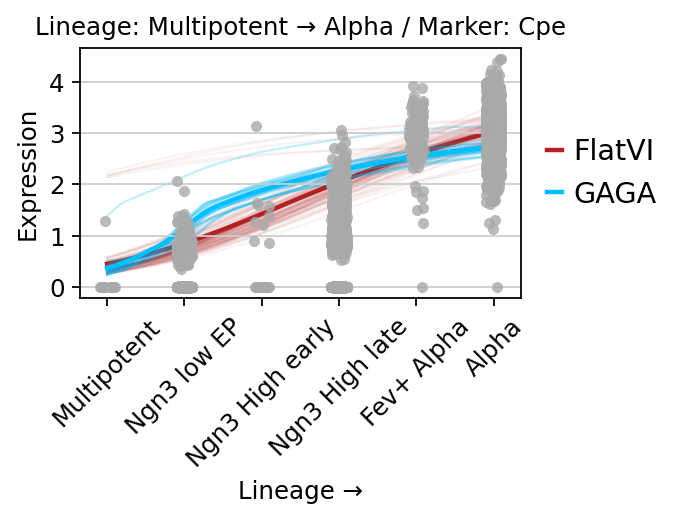

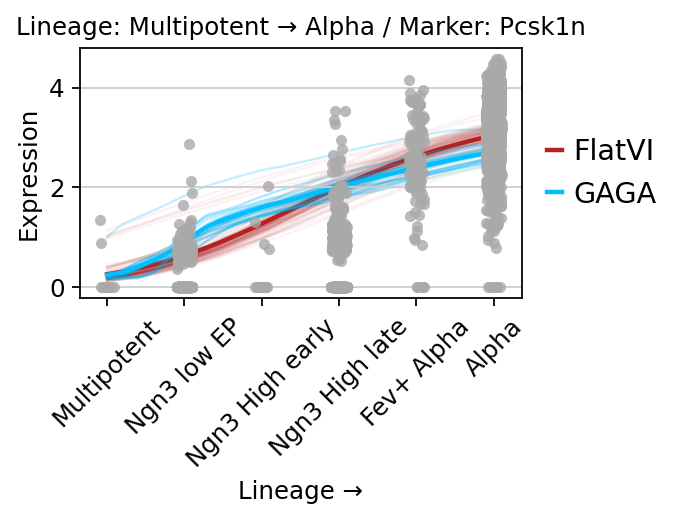

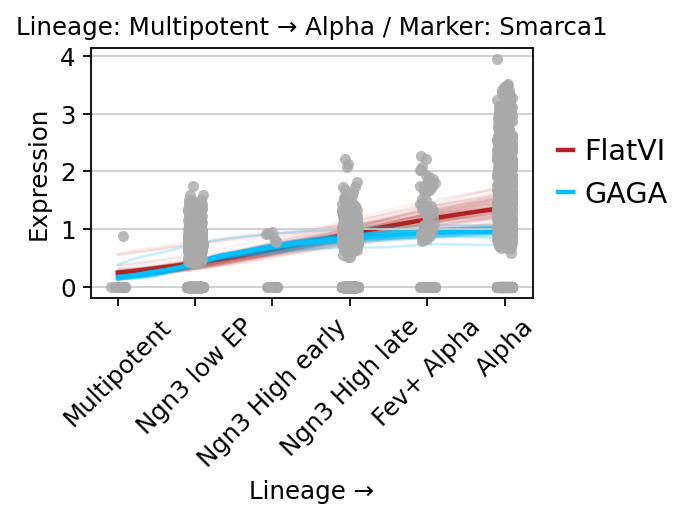

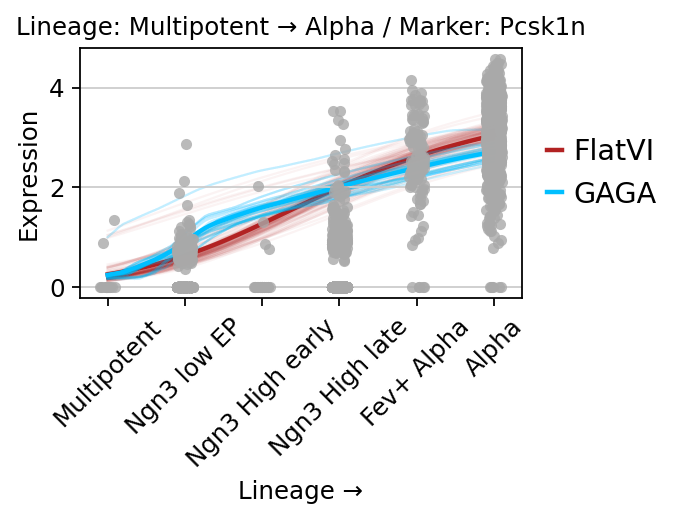

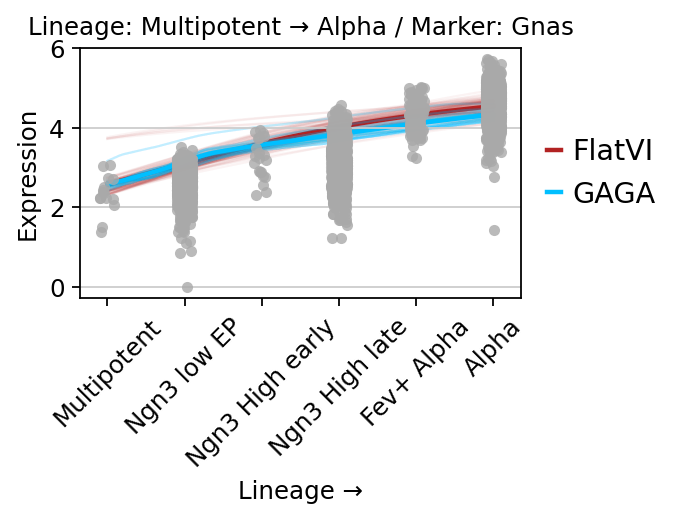

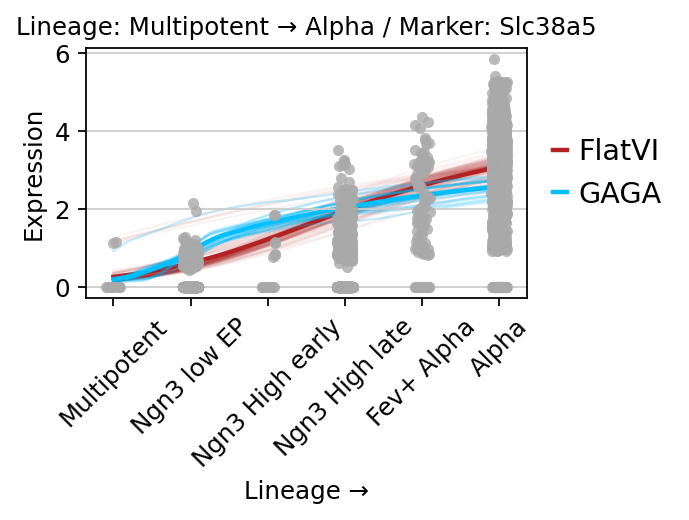

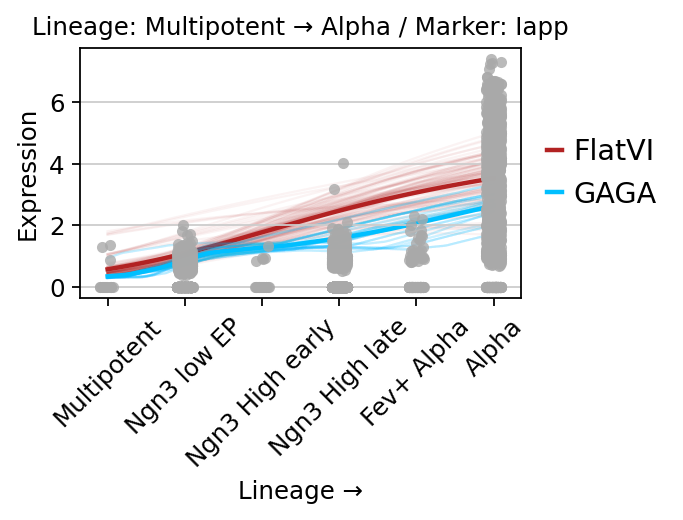

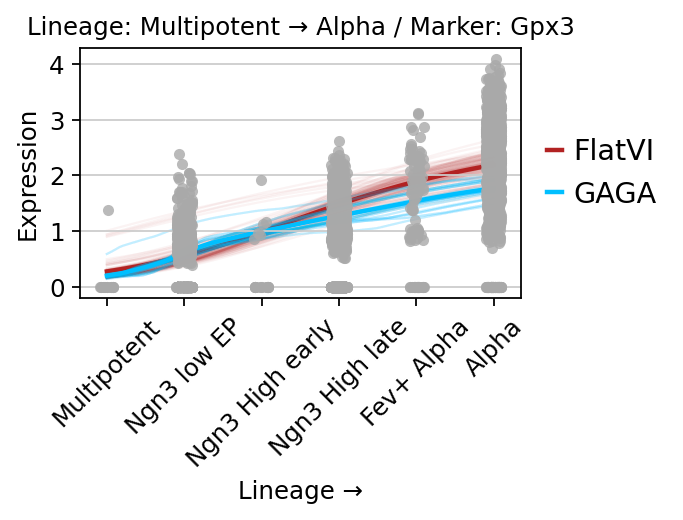

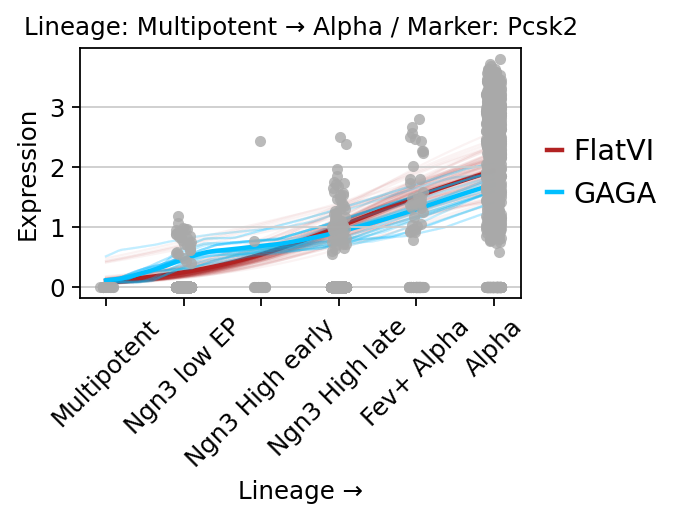

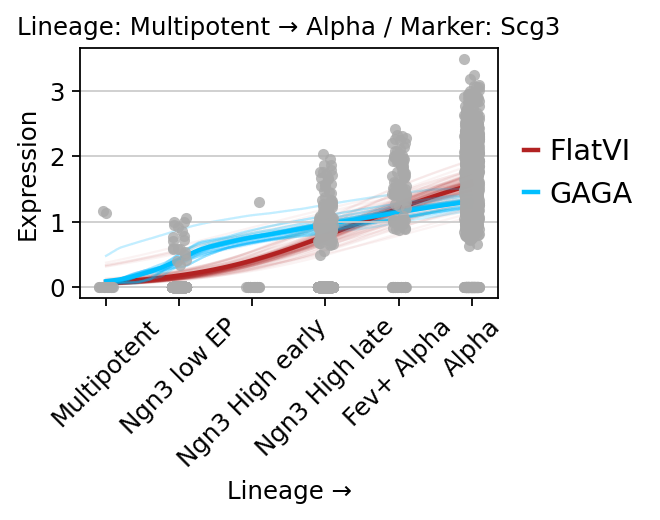

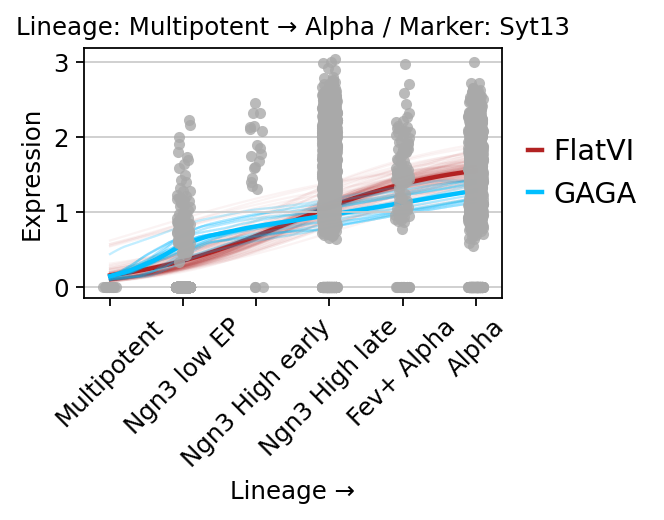

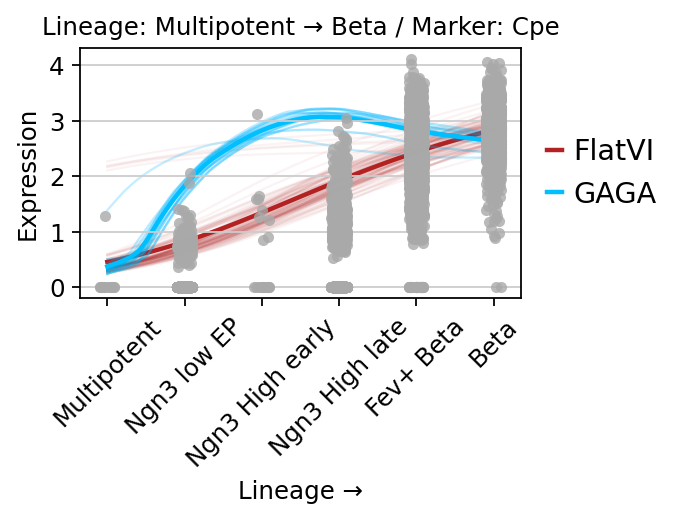

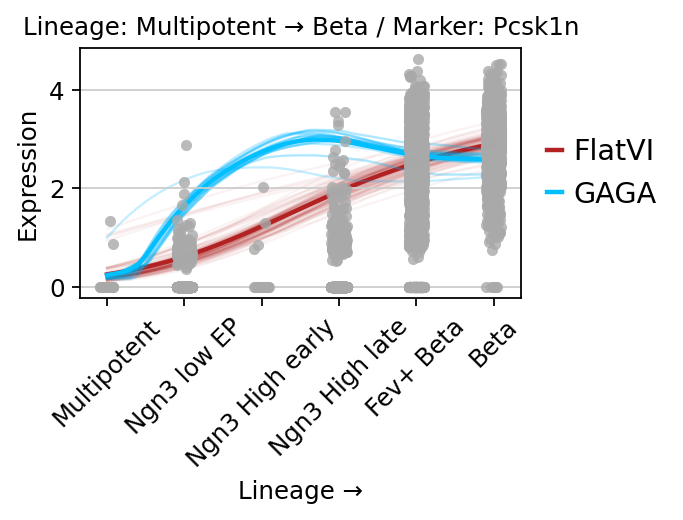

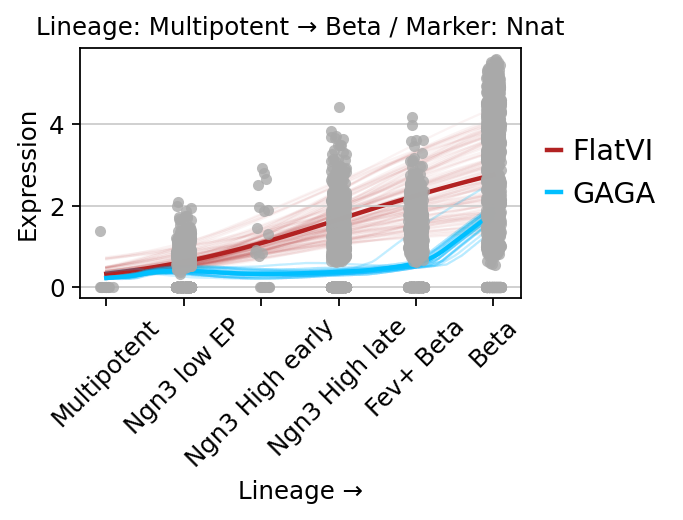

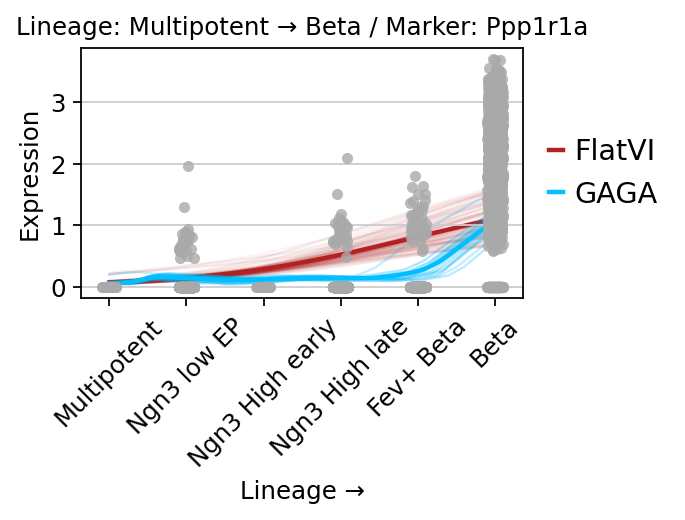

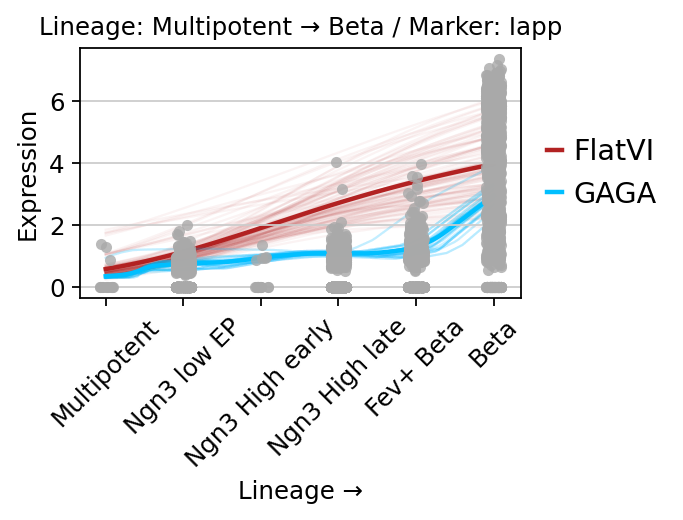

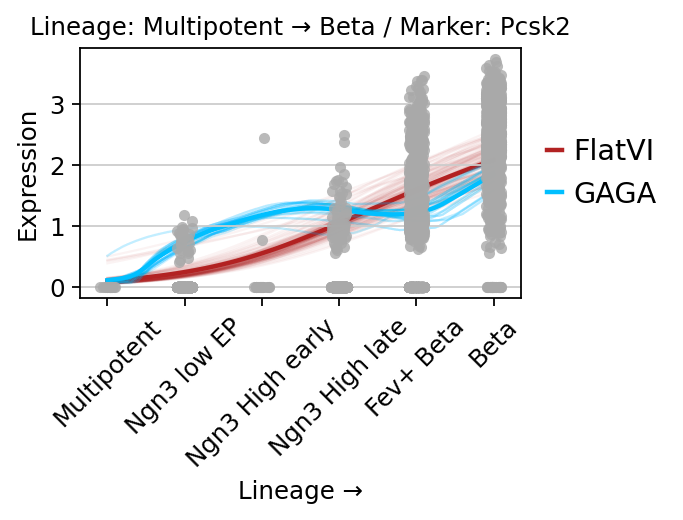

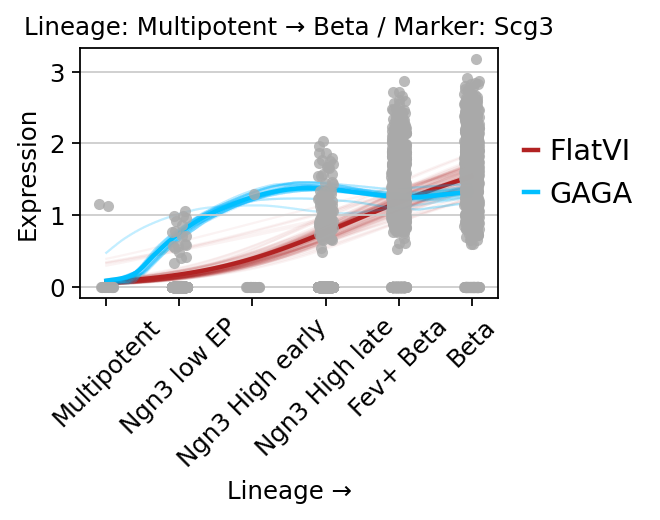

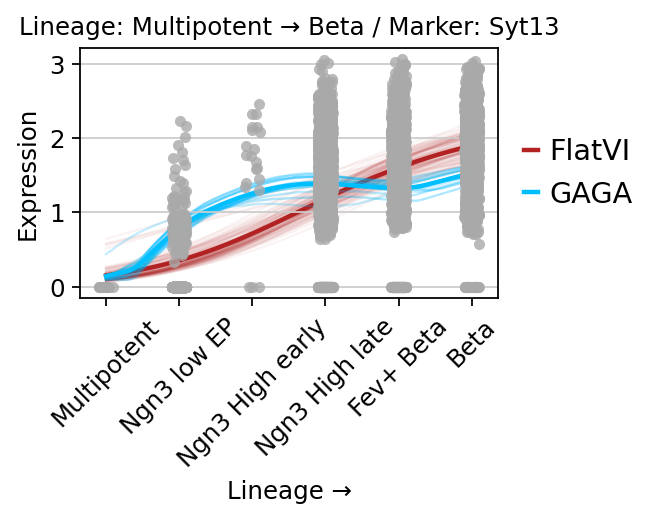

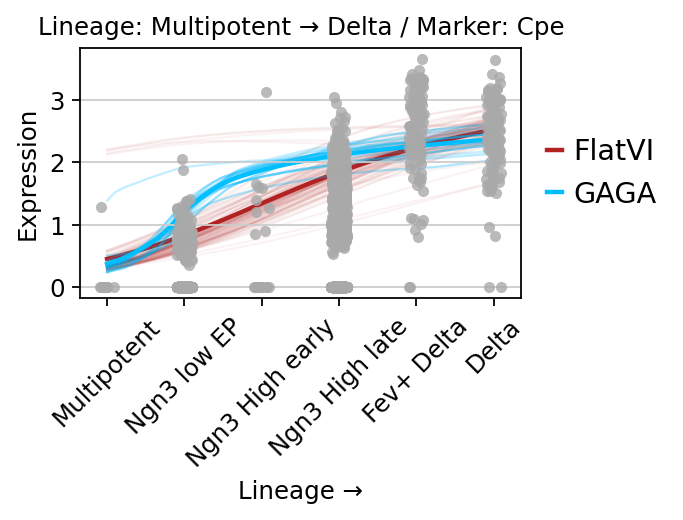

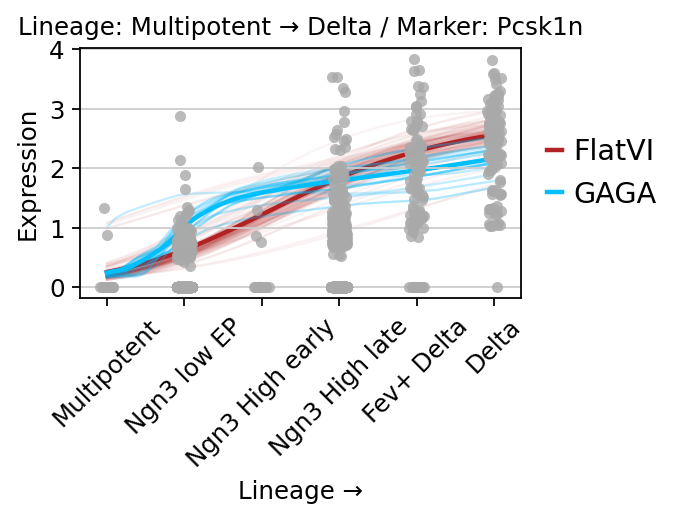

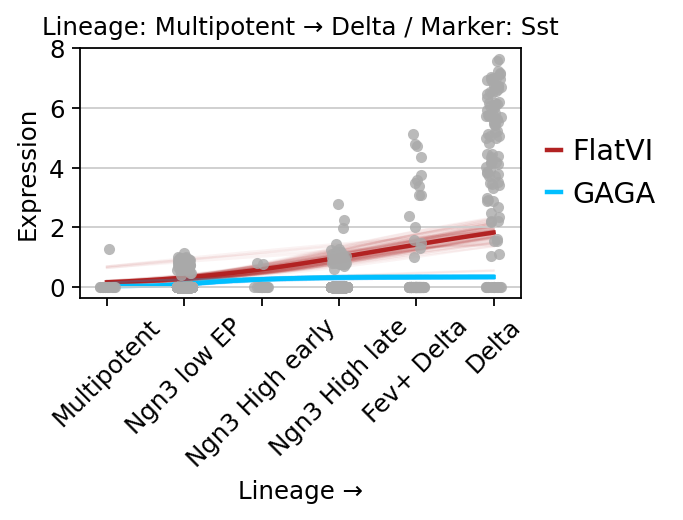

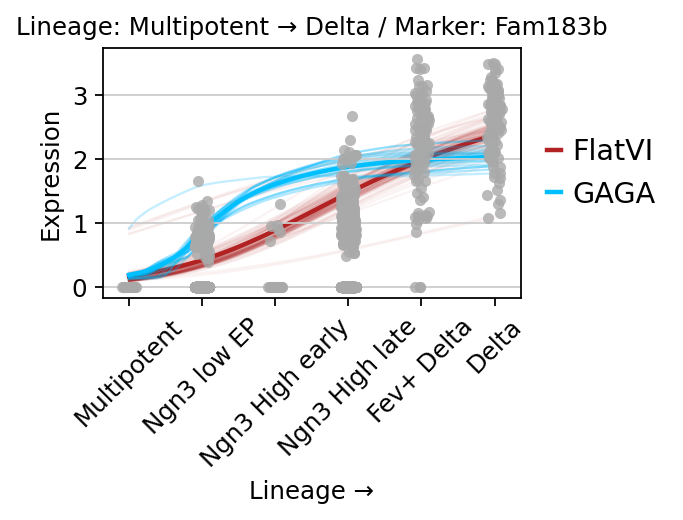

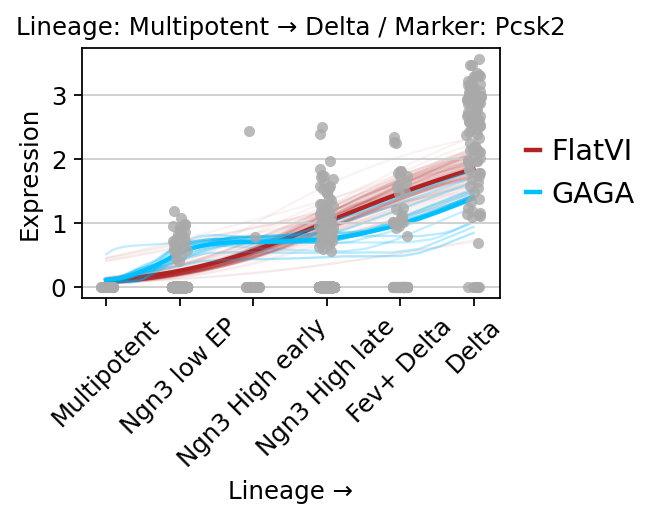

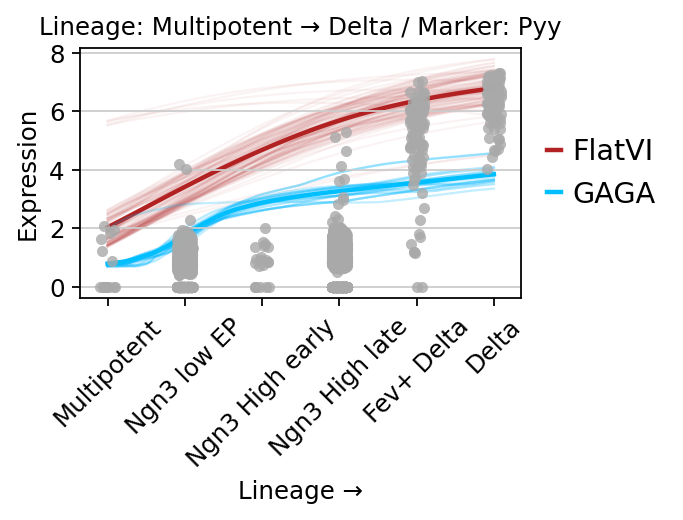

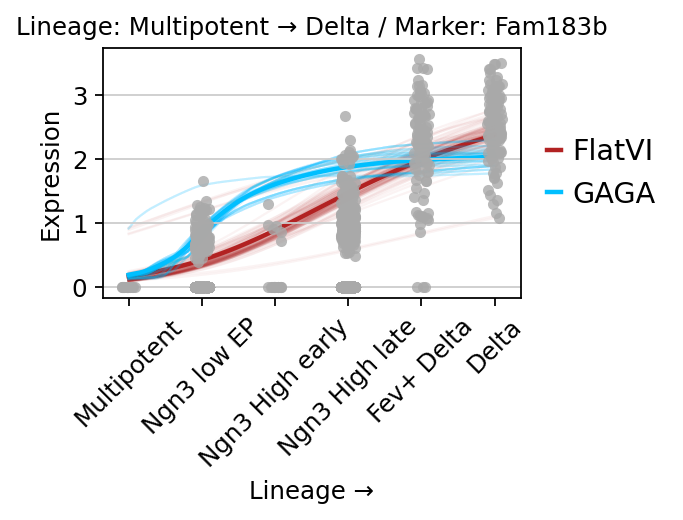

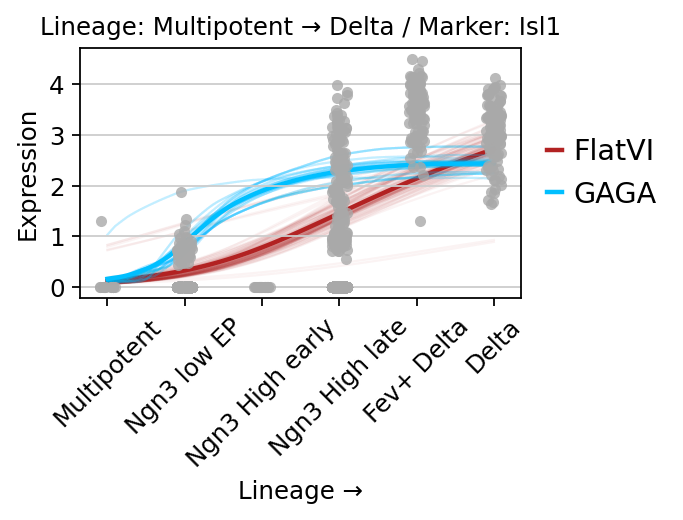

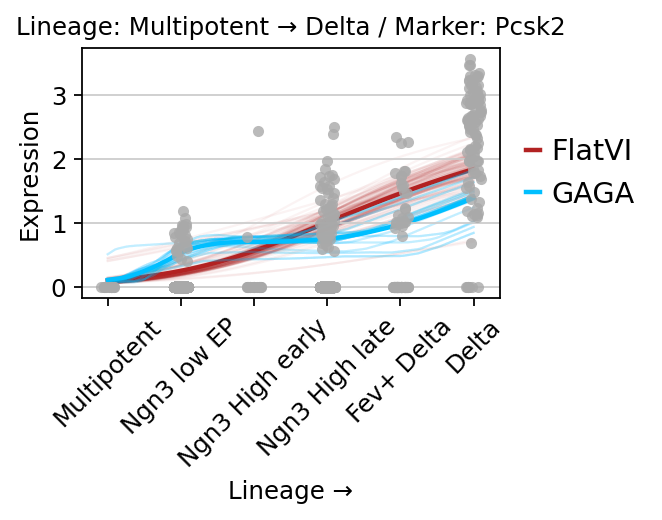

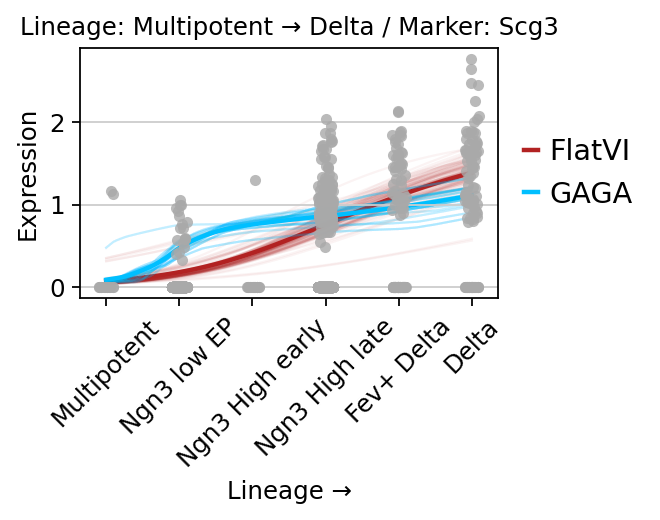

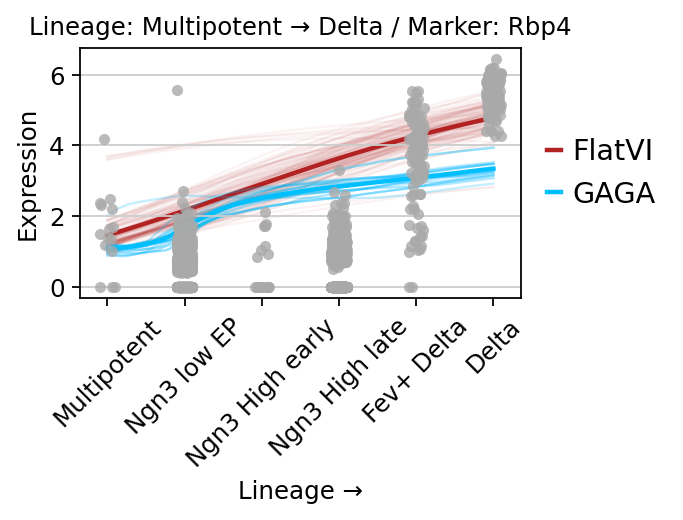

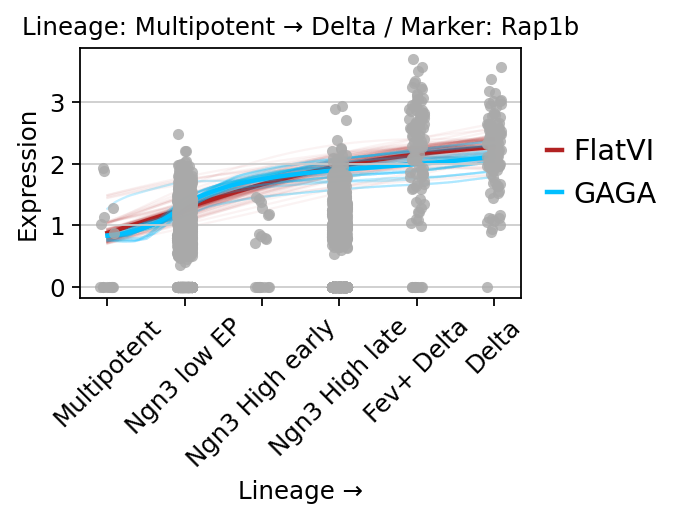

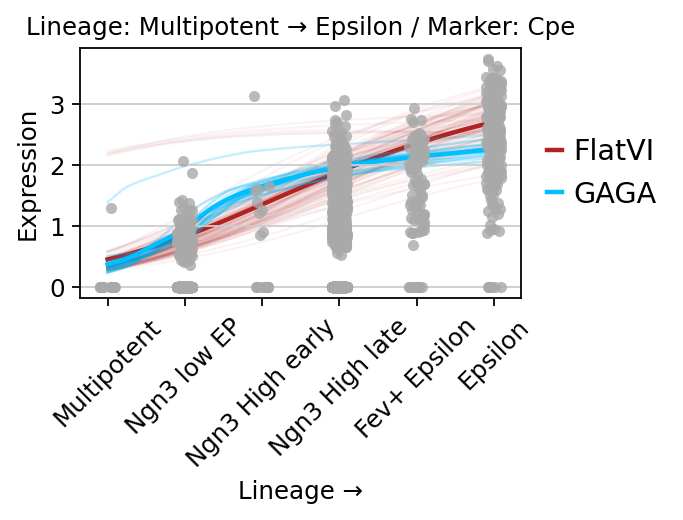

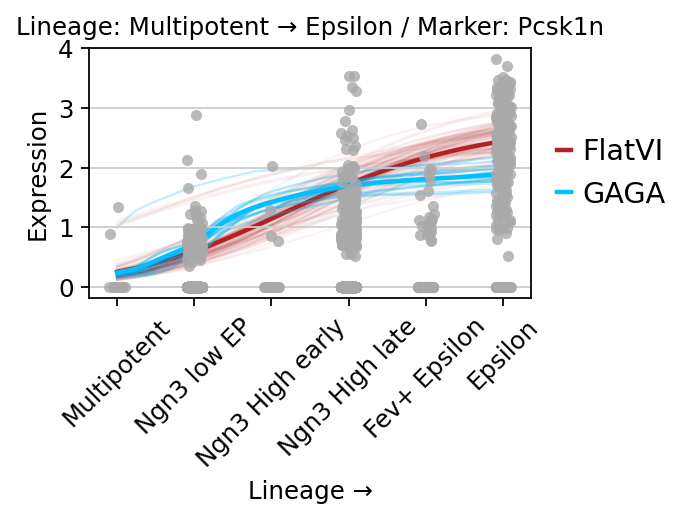

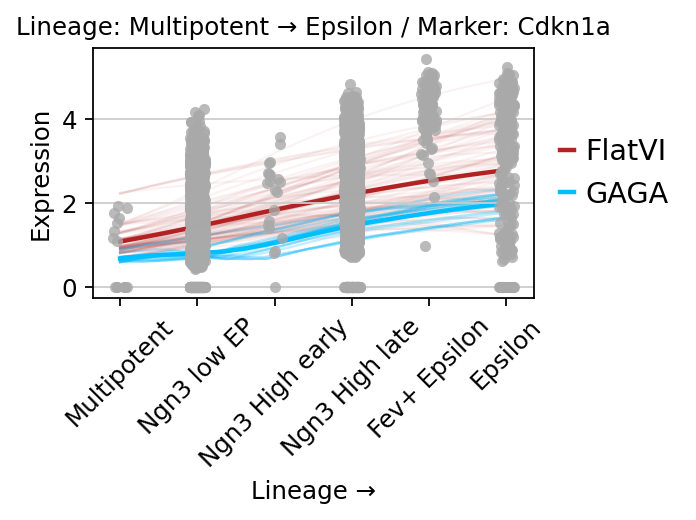

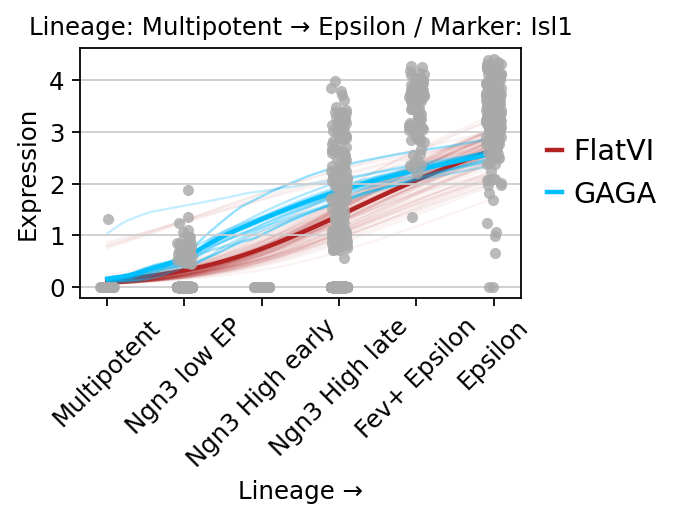

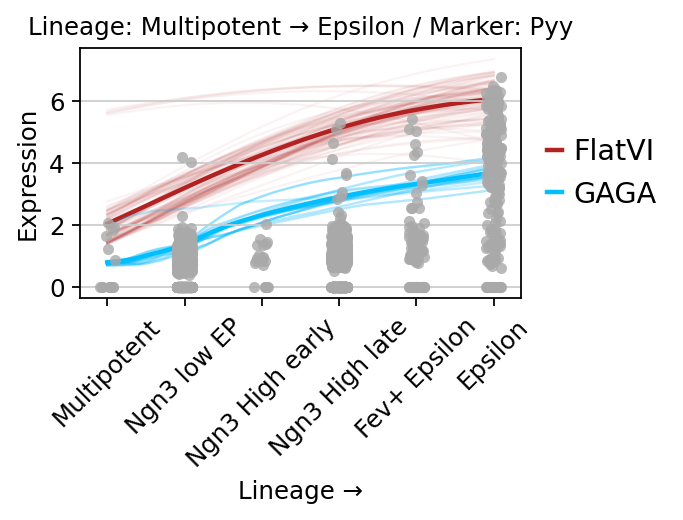

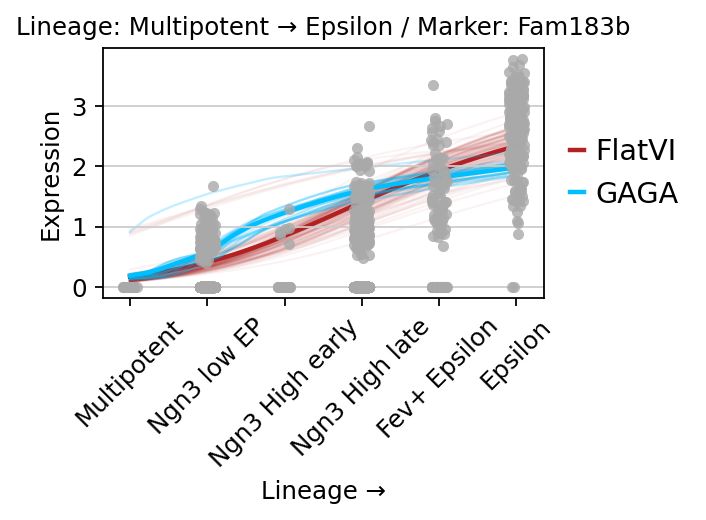

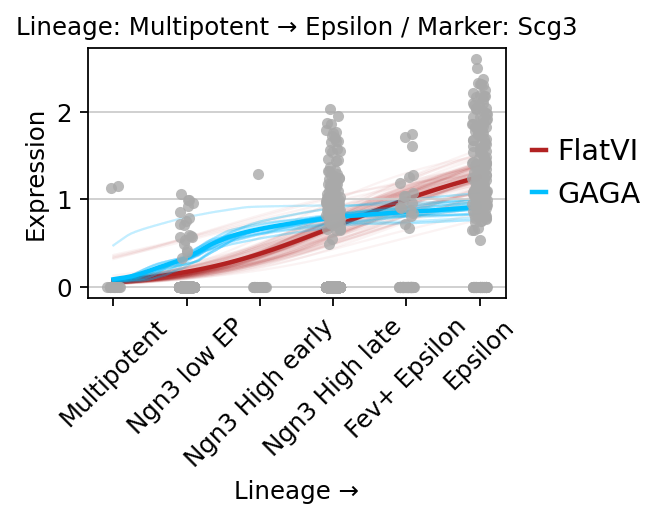

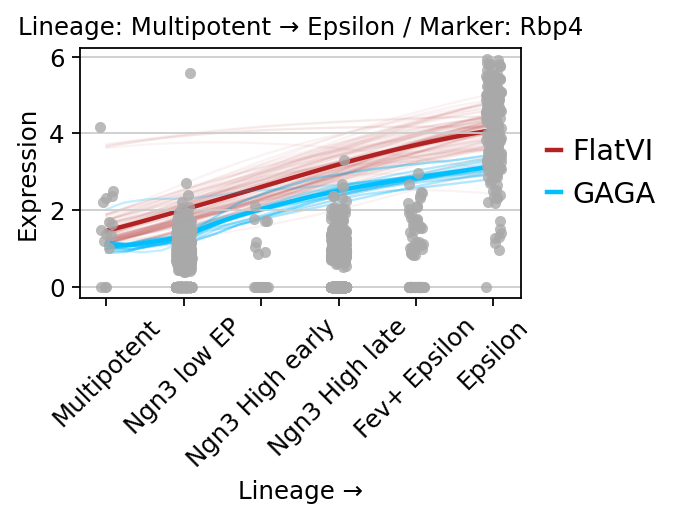

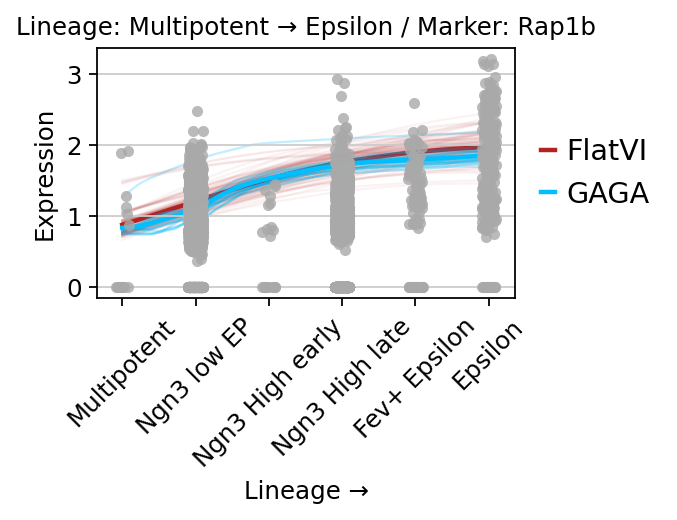

In [415]:
for celltype in pancreatic_lineage_markers:
    z_traj_ct, idx1, idx2 = interpolation_pair_ct(adata, 
                                      "Multipotent", 
                                      celltype,
                                      100,
                                      100,
                                      geometric_vae, return_idx=True)

    gaga_path = f"/lustre/groups/ml01/workspace/alessandro.palma/scCFM/baselines/gaga/predictions/{celltype}.pt"
    z_traj_ct_gaga = torch.load(gaga_path)
    
    ct_order = pancreatic_lineage_markers[celltype]["lineage"]
    for gene in pancreatic_lineage_markers[celltype]["markers"]:
        plot_gene_expression_by_celltype(adata, 
                                         ct_order, 
                                         gene, 
                                         z_traj_ct.numpy(), 
                                         z_traj_ct_gaga.numpy(),
                                         # plot_average=False,
                                         idx_ct1=idx1, 
                                         idx_ct2=idx2, 
                                         save_path=f"/lustre/groups/ml01/workspace/alessandro.palma/scCFM/baselines/gaga/comparisons/{celltype}_{gene}.svg",
                                         plt_legend=True
                                        )

In [ ]:
# import time

# timing_results_flatvi = {}

# for n_samples in [1000, 100, 50, 10, 5 ]:
#     start_time = time.time()
    
#     z_traj_ct = interpolation_pair_ct(adata, 
#                                       "Multipotent", 
#                                       celltype,
#                                       100,
#                                       n_samples,
#                                       geometric_vae)
    
#     end_time = time.time()
#     timing_results_flatvi[n_samples] = end_time - start_time

In [441]:
# timing_results_gaga = {1000: 41.84506368637085,
#                          100: 20.520017862319946,
#                          50: 21.484466075897217,
#                          10: 18.734952688217163,
#                          5: 18.185279607772827}

In [30]:
# timing_results_flatvi

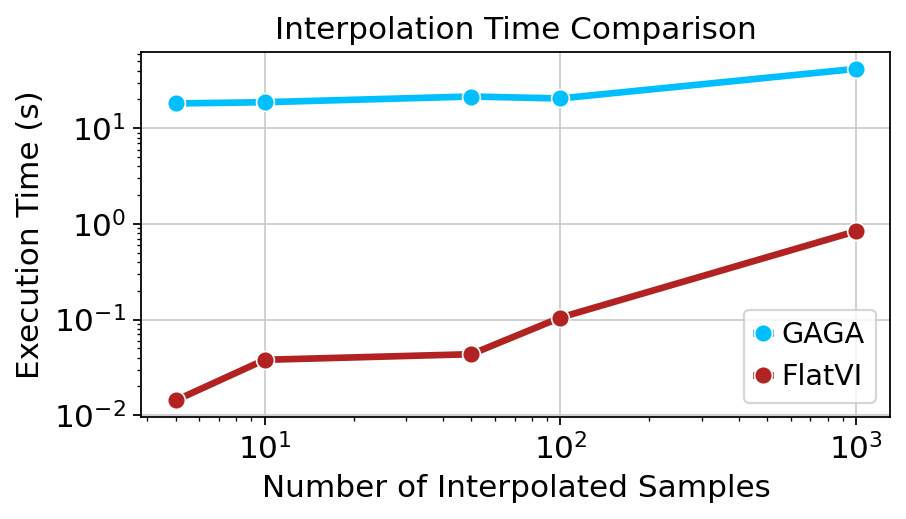

In [440]:
# Timing results
timing_results_gaga = {
    1000: 41.84506368637085,
    100: 20.520017862319946,
    50: 21.484466075897217,
    10: 18.734952688217163,
    5: 18.185279607772827
}

timing_results_flatvi = {
    1000: 0.8402566909790039,
    100: 0.10491275787353516,
    50: 0.04342794418334961,
    10: 0.03792858123779297,
    5: 0.014251947402954102
}

# Convert to DataFrame
df_gaga = pd.DataFrame({
    "Samples": list(timing_results_gaga.keys()),
    "Time (s)": list(timing_results_gaga.values()),
    "Model": "GAGA"
})

df_flatvi = pd.DataFrame({
    "Samples": list(timing_results_flatvi.keys()),
    "Time (s)": list(timing_results_flatvi.values()),
    "Model": "FlatVI"
})

# Merge the DataFrames
df = pd.concat([df_gaga, df_flatvi])

# Create line plot with custom colors
plt.figure(figsize=(6, 3))
sns.lineplot(
    data=df,
    x="Samples",
    y="Time (s)",
    hue="Model",
    marker="o",
    palette={"GAGA": "deepskyblue", "FlatVI": "firebrick"}, 
    linewidth=3,
    markersize=8
)

# Formatting
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Interpolated Samples")
plt.ylabel("Execution Time (s)")
plt.title("Interpolation Time Comparison")
# plt.grid(True, which="both", linestyle="--", linewidth=)
plt.legend()
plt.savefig("interpolation_time_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# def plot_gene_expression_by_celltype(adata, 
#                                      celltype_order, 
#                                      gene, 
#                                      predicted_expression=None, 
#                                      predicted_expression_baseline=None, 
#                                      plot_average=True,
#                                      idx_ct1=None,
#                                      idx_ct2=None
#                                     ):
#     """
#     Plots gene expression as a categorical scatter plot across specified cell types
#     and overlays an interpolated prediction curve if provided.
    
#     Parameters:
#     - adata: AnnData object containing gene expression and cell type annotations.
#     - celltype_order: List of cell type names in the desired order.
#     - gene: Name of the gene to plot.
#     - predicted_expression: Tensor of shape (100, 10, 2000) where
#       (timepoints, cells, genes). If None, only real expression is plotted.
#     """
#     # Check if gene exists
#     if gene not in adata.var_names:
#         raise ValueError(f"Gene '{gene}' not found in adata.var_names.")

#     # Get gene index
#     gene_idx = list(adata.var_names).index(gene)

#     # Extract real expression for the selected gene and relevant cell types
#     plot_data = []
#     for celltype in celltype_order:
#         expr_values = adata[adata.obs["celltype"] == celltype].X[:, gene_idx].toarray().flatten()
#         plot_data.append(pd.DataFrame({"Expression": expr_values, "Cell Type": celltype}))

#     df_plot = pd.concat(plot_data)

#     # Create figure
#     plt.figure(figsize=(3, 3))

#     # Plot real expression using seaborn catplot
#     sns.catplot(
#         data=df_plot, 
#         x="Cell Type", 
#         y="Expression", 
#         order=celltype_order, 
#         kind="strip",  # Scatter points in columns
#         jitter=True, 
#         dodge=False, 
#         aspect=1.5, 
#         height=3, 
#         color="darkgray", 
#         legend=False, 
#         alpha=0.3
#     )

#     if idx_ct1 is not None and idx_ct2 is not None:
#         sns.scatterplot(x=np.zeros(predicted_expression.shape[1]),
#                         y=df_plot.loc[df_plot["Cell Type"]==celltype_order[0], "Expression"].to_numpy()[idx_ct1], color="dimgrey")
#         sns.scatterplot(x=np.ones(predicted_expression.shape[1])*(len(celltype_order)-1),
#                         y=df_plot.loc[df_plot["Cell Type"]==celltype_order[-1], "Expression"].to_numpy()[idx_ct2], color="dimgrey")
    

#     # Convert cell type order to numeric x-axis positions
#     celltype_positions = np.arange(len(celltype_order))

#     # Overlay predicted expression if provided
#     if predicted_expression is not None:
#         timepoints = np.linspace(0, len(celltype_order) - 1, 100)  # Map [0,100] → [0, # cell types]

#         if plot_average:
#             # Compute mean over 10 trajectories
#             pred_mean = np.mean(predicted_expression[:, :, gene_idx], axis=1)  # Shape: (100,)
#             sns.lineplot(x=timepoints, y=pred_mean, color="firebrick", lw=2, label="Predicted (Mean)", legend=False)
#             if predicted_expression_baseline is not None:
#                 pred_mean_baseline = np.mean(predicted_expression_baseline[:, :, gene_idx], axis=1)  # Shape: (100,)
#                 sns.lineplot(x=timepoints, y=pred_mean_baseline, color="deepskyblue", lw=2, label="Predicted (Mean)", legend=False)
#         else:
#             # Plot each trajectory separately
#             for i in range(predicted_expression.shape[1]):
#                 # Plot FlatVI trajectories (dimmed, no label)
#                 sns.lineplot(x=timepoints, y=predicted_expression[:, i, gene_idx], 
#                              color="firebrick", alpha=0.3, lw=1, label=None)
#                 # Plot GAGA trajectories (dimmed, no label)
#                 if predicted_expression_baseline is not None:
#                     sns.lineplot(x=timepoints, y=predicted_expression_baseline[:, i, gene_idx], 
#                                  color="deepskyblue", alpha=0.3, lw=1, label=None)
            
#             # Add a single representative line for the legend
#             # FlatVI
#             sns.lineplot(x=timepoints, y=predicted_expression[:, 0, gene_idx], 
#                          color="firebrick", alpha=1, lw=2, label="FlatVI")
#             # GAGA
#             if predicted_expression_baseline is not None:
#                 sns.lineplot(x=timepoints, y=predicted_expression_baseline[:, 0, gene_idx], 
#                              color="deepskyblue", alpha=1, lw=2, label="GAGA")
        
#         # Final formatting
#         plt.legend()
#         plt.xticks(celltype_positions, celltype_order, rotation=45)
#         plt.xlabel("Cell Type")
#         plt.ylabel(f"Expression")
#         plt.title(f"Lineage: {celltype_order[0]} → {celltype_order[-1]} / Marker: {gene}")
        
#         plt.show()
